# Model Evaluation 

## Set Up

In [51]:
import joblib
import pandas as pd
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

### Load Model 

In [52]:

random_search = joblib.load("vehicle_model.pkl")

### Load Test Train Split 

In [53]:


with open("X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

print("Train/test sets loaded successfully.")

Train/test sets loaded successfully.


## Run Model 

In [54]:

y_pred_log = random_search.predict(X_test)



## Convert Log Price 

In [55]:

y_pred_price = np.expm1(y_pred_log)
y_test_price = np.expm1(y_test)   # actual prices
residuals_price = y_test_price - y_pred_price


## Evaluating Residuals 

In [56]:

rmse_price = mean_squared_error(y_test_price, y_pred_price, squared=False)
mae_price = mean_absolute_error(y_test_price, y_pred_price)
r2_price = r2_score(y_test_price, y_pred_price)

print(f"RMSE (£): {rmse_price:,.2f}")
print(f"MAE (£): {mae_price:,.2f}")
print(f"R²: {r2_price:.2f}")


RMSE (£): 1,329.07
MAE (£): 772.77
R²: 0.92


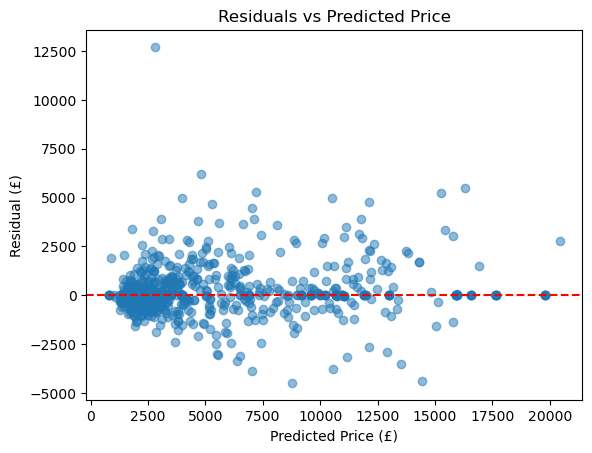

In [57]:


plt.scatter(y_pred_price, residuals_price, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price (£)')
plt.ylabel('Residual (£)')
plt.title('Residuals vs Predicted Price')
plt.show()


## Permutation Importance

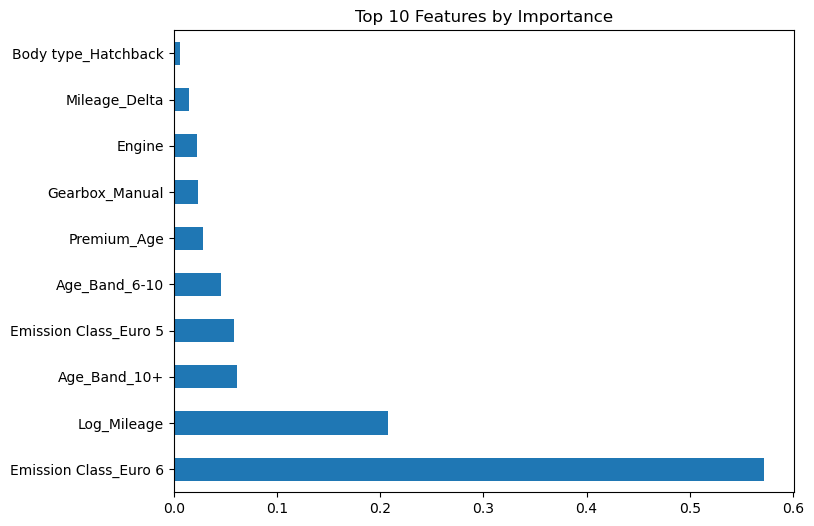

In [58]:


perm = permutation_importance(grid_search, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring='r2')
perm_importance = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)
perm_importance.head(10).plot(kind='barh', figsize=(8,6), title='Top 10 Features by Importance')
plt.show()


In [59]:
analysis_df = X_test.copy()
analysis_df['Actual Price (£)'] = y_test_price
analysis_df['Predicted Price (£)'] = y_pred_price
analysis_df['Residual (£)'] = residuals_price

undervalued = analysis_df[analysis_df['Residual (£)'] > 0].sort_values('Residual (£)', ascending=False)
overvalued = analysis_df[analysis_df['Residual (£)'] < 0].sort_values('Residual (£)')

print("Top 5 undervalued vehicles:\n", undervalued.head())
print("Top 5 overvalued vehicles:\n", overvalued.head())


Top 5 undervalued vehicles:
      Previous Owners  Engine  Doors  Seats  Has_Service_History  Mileage  \
276                4     1.8    4.0    5.0                    0        6   
671                6     2.0    5.0    5.0                    0    80000   
453                3     1.5    5.0    5.0                    0    12080   
66                 3     2.0    5.0    5.0                    0    60000   
522                3     1.6    5.0    5.0                    1    25162   

     Car_Age  Mileage_per_Year  Log_Mileage  Expected_Mileage  ...  \
276       19          0.315789     1.791759            171000  ...   
671       13       6153.846154    11.289782            117000  ...   
453        3       4026.666667     9.399306             27000  ...   
66         9       6666.666667    11.002100             81000  ...   
522        2      12581.000000    10.133090             18000  ...   

     Model_Zafira Tourer  Usage_Level_Low  Usage_Level_Normal  \
276                False    

## Undervalued Vehicles 

**Interpretation:**

- These vehicles sold for much more than the model expected.

**Possible reasons:**

- rare model, low mileage, highly desirable brand/engine, or market timing.

**Actionable:**

- Consider highlighting these cars in listings or prioritizing them for marketing.

- Use these residuals to calibrate pricing strategies as model underestimated.

## Overvalued Vehicles 

**Interpretation:**

- These vehicles sold for much less than predicted.

**Possible reasons:**

- high mileage, poor condition, less desirable features, or mispricing.

**Actionable:**

- Avoid overpricing these in future listings.

- Analyse why these cars underperformed (service history, owners, mileage, or model popularity).

## How to use these insights

**Pricing Strategy:**

Adjust listing prices for over/under-performing segments using residuals.

**Example:**

add a buffer for undervalued cars, discount overvalued ones.

**Marketing Priorities:**

Highlight features that the model underestimates (e.g., rare trims, popular engines).

**Inventory Planning:**

Acquire vehicles that tend to outperform predictions — low mileage, desirable engine, Euro 5/6 class.

Avoid over-investing in vehicles that consistently underperform.

**Model Calibration:**

Large residuals indicate where the model is under- or over-predicting.
Could be used to refine feature engineering or create segment-specific models.

In [60]:
rf = random_search.best_estimator_


In [67]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [71]:
import joblib

# Save pipeline (example)
joblib.dump(grid_search.best_estimator_, "vehicle_rf_pipeline.pkl")

# Load pipeline
pipeline = joblib.load("vehicle_rf_pipeline.pkl")



In [73]:
# Preprocess X_test first
X_test_preprocessed = rf.named_steps['preprocessor'].transform(X_test)

# Extract regressor
rf_model = rf.named_steps['regressor']

# SHAP
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_preprocessed)

shap.summary_plot(shap_values, X_test_preprocessed, feature_names=X_test.columns)



AttributeError: 'RandomizedSearchCV' object has no attribute 'named_steps'

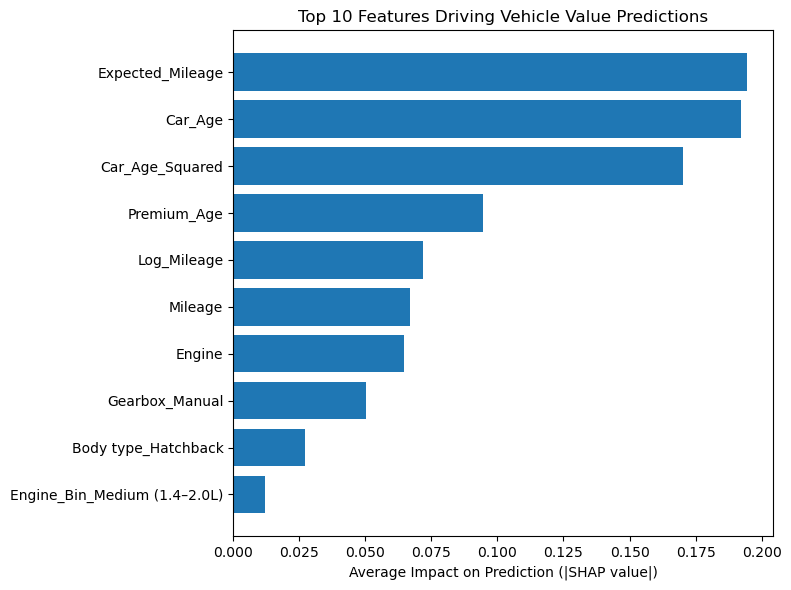

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert SHAP values to DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

# Rank by impact
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

# Direction of effect
mean_shap = shap_df.mean()

feature_effects = pd.DataFrame({
    "Feature": mean_abs_shap.index,
    "Mean_Abs_SHAP": mean_abs_shap.values,
    "Mean_SHAP": mean_shap[mean_abs_shap.index].values
})

# Top 10 features
top10 = feature_effects.head(10)

# ---- Business-friendly horizontal plot ----
plt.figure(figsize=(8,6))
plt.barh(top10["Feature"][::-1], top10["Mean_Abs_SHAP"][::-1])
plt.xlabel("Average Impact on Prediction (|SHAP value|)")
plt.title("Top 10 Features Driving Vehicle Value Predictions")
plt.tight_layout()
plt.show()


In [65]:
top10 = feature_effects.head(10).copy()

top10["Effect"] = np.where(
    top10["Mean_SHAP"] > 0,
    "Generally increases value",
    "Generally decreases value"
)

top10



,Feature,Mean_Abs_SHAP,Mean_SHAP,Effect
0,Expected_Mileage,0.194494,0.006136,Generally increases value
1,Car_Age,0.192038,0.006030,Generally increases value
2,Car_Age_Squared,0.170031,0.005606,Generally increases value
3,Premium_Age,0.094515,-0.012326,Generally decreases value
4,Log_Mileage,0.071952,0.009169,Generally increases value
5,Mileage,0.066862,0.009442,Generally increases value
6,Engine,0.064581,-0.007540,Generally decreases value
7,Gearbox_Manual,0.050441,-0.006328,Generally decreases value
8,Body type_Hatchback,0.027114,-0.002528,Generally decreases value
9,Engine_Bin_Medium (1.4–2.0L),0.011997,0.002471,Generally increases value
